# Segmentation fine-tuning tutorial
Tutorial from: 

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

For this tutorial, we will be finetuning a pre-trained Mask R-CNN model on the Penn-Fudan Database for Pedestrian Detection and Segmentation. It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an object detection and instance segmentation model on a custom dataset.

In [1]:
import os
import torch
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

# Defining the Dataset
The reference scripts for training object detection, instance segmentation and person keypoint detection allows for easily supporting adding new custom datasets. The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

## Writing a custom dataset for PennFudan
Let’s write a dataset for the PennFudan dataset. After downloading and extracting the zip file, the data will include the following (in addition to some others).

    PennFudanPed/
        Annotation/  # includes bounding boxes
            FudanPed00001.txt
            FudanPed00002.txt
            FudanPed00003.txt
            FudanPed00004.txt
            ...
        
        PedMasks/  # includes segmentation masks
            FudanPed00001_mask.png
            FudanPed00002_mask.png
            FudanPed00003_mask.png
            FudanPed00004_mask.png
            ...
        PNGImages/  # includes images 
            FudanPed00001.png
            FudanPed00002.png
            FudanPed00003.png
            FudanPed00004.png
            ...


Path to penn dataset:

In [2]:
data_path = r'C:/Users/Eric/development/data/PennFudanPed/'

Dataset class just gets N masks (N binary masks, encoded as uint8, bounding boxes and their areas, labels, and images):

In [3]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.images = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        image_path = os.path.join(self.root, "PNGImages", self.images[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        image = read_image(image_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        image = tv_tensors.Image(image)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.images)

# Defining model

We will start from a pre-trained model trained on the coco dataset, and fine-tune the last layer.

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

That’s it, this will make model be ready to be trained and evaluated on your custom dataset.

## Pulling in bits for training
There are some helper functions to simplify training and evaluating detection models. Here, we will use `engine.py` and `utils.py` from our object detection reference repo.

Just download everything under https://github.com/pytorch/vision/tree/main/references/detection to your folder and use them here:

In [5]:
import utils
from engine import train_one_epoch, evaluate

In [6]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

Following is necessary when working in windows, otherwise can set to 4. :(

In [7]:
num_torch_workers = 0

Wrapping dataset into dataloader.
Note we haven't discussed data loader. It is discussed, in context of dataset, here:

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### What if you don't use utils.collate_fun() ?
When you don't use their collate function (see code below), you get a list of batch items back,
each contains a tuple containing image/target. 

utils.collate_fun creates a tuple of length num_batches, first contains images, second contains
targets. This division makes it more convenient to get all the images, all the targets for 
the entire epoch all at once. 

Representative output (batch_size 2)

    Len and type of batch data  2 <class 'list'>
    Type/len of batch item <class 'tuple'> 2
    Type of first, second elemenents in first batch item: <class 'torch.Tensor'> <class 'dict'>

    (torch.Size([3, 380, 423]),
     dict_keys(['boxes', 'masks', 'labels', 'image_id', 'area', 'iscrowd'])

In [31]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset(data_path, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=2, 
                                          shuffle=True, 
                                          num_workers=num_torch_workers, 
                                          collate_fn=utils.collate_fn) # custom_collate

In [41]:
# Aside: What happens when you don't use utils.collate_fn?

# def custom_collate(batch):
#     return batch
    
# batch_data = next(iter(data_loader))
# print("Len and type of batch data ", len(batch_data), type(batch_data))

# batch_ind = 0
# batch_item = batch_data[batch_ind]
# print("Type/len of batch item", type(batch_item), len(batch_item))
# batch_image = batch_item[0]
# batch_target = batch_item[1]
# batch_image.shape, batch_target.keys()

For Training we use the iterable dataloader (for more see https://stackoverflow.com/a/77654159/1886357).

Aside: let's look at standard kinds of syntax for extracting images and targets in a batch (note in practice you will typically not use `next(iter(loader))`, but would have it in a loop which iterates through the loader):

In [18]:
images, targets = next(iter(data_loader))

(tuple, tuple)

The data loader returns two tuples, the first contains the `num_batch` images in the batch, second contains the `num_batch` target dictionaries in the batch (could do `train_batch = next(iter(data_loader))` and unpack the tuple following is more explicit so let's go with that:

In [ ]:
type(images), type(targets)

Standard syntax for extracting list of images and targets in the batch, so you can get image i and target i with `images[i]` and `targets[i]` respectively. 

In [45]:
images = list(image for image in images)
# list of target dictionaries
targets = [{k: v for k, v in t.items()} for t in targets]
len(images), len(targets)

(2, 2)

In [12]:
# making sure __getitem__ worked
targets[0].keys()

dict_keys(['boxes', 'masks', 'labels', 'image_id', 'area', 'iscrowd'])

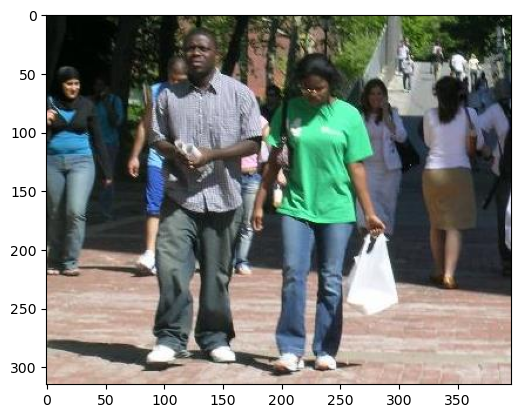

In [14]:
plt.imshow(images[0].permute(1,2,0));

## Getting more serious: defining functions for training

Let’s now write the main function which performs the training and the validation:

In [50]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [51]:
# our dataset has two classes only - background and person
num_classes = 2

In [52]:
# use our dataset and defined transformations
dataset = PennFudanDataset(data_path, get_transform(train=True))
dataset_test = PennFudanDataset(data_path, get_transform(train=False))

In [53]:
# split the dataset in train and test set (50 test sessions)
# this could be done much better
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [54]:
num_train = len(dataset)
num_test = len(dataset_test)
print(num_train, num_test)

120 50


In [55]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,  #2
    shuffle=True,
    num_workers=num_torch_workers,
    collate_fn=utils.collate_fn
)

In [56]:
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=num_torch_workers,
    collate_fn=utils.collate_fn
)

In [57]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

In [58]:
# move model to the right device
model.to(device);

In [59]:
print(device)

cuda


In [60]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005)

In [61]:
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

## Let's build up training how we want it 
Note this is adapted from:    
https://github.com/DatumLearning/Mask-RCNN-finetuning-PyTorch/blob/main/notebook.ipynb

(This is new: cells below are how it is done in tutorial)
- Use same metrics for train/val set
- Save checkpoints 
- Save loss for train-/val set so we can compare for early stopping and it is apples to apples
    - we can do the coco eval metrics once we are happy with our network and are evaluating it.
 
To do: 
- Add warmup on epoch 0.
- Add functionality to print every N, save checkpoint every M. 

In [80]:
num_epochs = 3

In [83]:
all_train_losses = []
all_val_losses = []
for epoch in range(num_epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0

    ### TRAIN STEP
    print(f"Epoch {epoch}")
    print("Train step")
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss = model(images , targets)
        # print(loss)
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    # VAL STEP
    print(f"Validation step in epoch {epoch}")
    with torch.no_grad():
        for j, (images_val, targets_val) in enumerate(data_loader_test):
            images_val = list(image.to(device) for image in images_val)
            targets_val = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets_val]
            loss_val = model(images_val, targets_val)
            losses_val = sum([l for l in loss_val.values()])
            val_epoch_loss += losses_val.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch, " ", train_epoch_loss, " ", val_epoch_loss)

print("\nDONE!")        

Epoch 0
Train step
Validation step in epoch 0
0   11.414661765098572   10.390875071287155
Epoch 1
Train step
Validation step in epoch 1
1   11.310377314686775   10.450453072786331
Epoch 2
Train step
Validation step in epoch 2
2   10.435619302093983   10.7292700111866

DONE!


In [85]:
import numpy as np

Seems we have the foundation to start doing early stopping, true train/val. 

Text(0, 0.5, 'net loss')

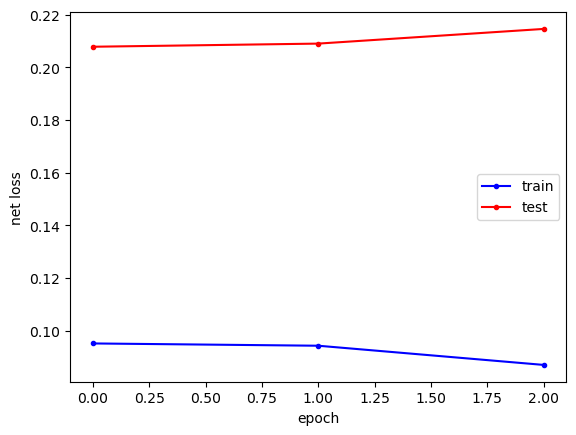

In [87]:
plt.plot(np.array(all_train_losses)/num_train, color='blue', marker='.', label='train')
plt.plot(np.array(all_val_losses)/num_test, color='red', marker='.', label='test')
plt.legend();
plt.xlabel('epoch')
plt.ylabel('net loss')

## Training as in tutorial -- no saving of loss, no checkpoints
- The following doesn't seem built for practical ML eg for early stopping** -- this is what I want to change!
- No checkpoints saved
- Also is it weird it doesn't normalize/standardize the images like most of these faster-rcnn network tutorials do? Is that an issue?

On the evaluation metrics:    
https://debuggercafe.com/evaluation-metrics-for-object-detection/


In [ ]:
# let's train it for 5 epochs just making sure things work
num_epochs = 5

In [27]:
for epoch in range(num_epochs):
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    
    # update the learning rate
    lr_scheduler.step()
    torch.cuda.empty_cache()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    torch.cuda.empty_cache()

print("\n**DONE!**")

Epoch: [0]  [ 0/60]  eta: 0:06:06  lr: 0.000090  loss: 3.5411 (3.5411)  loss_classifier: 0.6650 (0.6650)  loss_box_reg: 0.3456 (0.3456)  loss_mask: 2.5123 (2.5123)  loss_objectness: 0.0085 (0.0085)  loss_rpn_box_reg: 0.0096 (0.0096)  time: 6.1020  data: 0.0690  max mem: 1910
Epoch: [0]  [20/60]  eta: 0:00:29  lr: 0.001783  loss: 1.0128 (1.4261)  loss_classifier: 0.2215 (0.3139)  loss_box_reg: 0.2813 (0.2927)  loss_mask: 0.4378 (0.7964)  loss_objectness: 0.0178 (0.0168)  loss_rpn_box_reg: 0.0051 (0.0064)  time: 0.4605  data: 0.0456  max mem: 2769
Epoch: [0]  [40/60]  eta: 0:00:11  lr: 0.003476  loss: 0.4812 (0.9825)  loss_classifier: 0.0707 (0.1998)  loss_box_reg: 0.2213 (0.2661)  loss_mask: 0.1807 (0.4976)  loss_objectness: 0.0047 (0.0132)  loss_rpn_box_reg: 0.0044 (0.0058)  time: 0.4450  data: 0.0446  max mem: 2769
Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.3294 (0.7874)  loss_classifier: 0.0375 (0.1500)  loss_box_reg: 0.1064 (0.2246)  loss_mask: 0.1653 (0.3955)  loss_ob

So after one epoch of training, we obtain a COCO-style mAP > 50 for boxes, and > 65 for masks.

**Note added**    
- Arguably the most important part of the fine-tuning tutorial, the above is not very helpful.
  - No plots of learning, why we use different metrics for training/validation, no discussion of validation or early stopping, or other practical matters  
  -  How to adapt with actual data in realistic use case?
- How do we do garbage collection when done in torch?

## Inspect results
But what do the predictions look like? Let’s take one image in the dataset and verify

In [28]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

In [29]:
image = read_image("./tv_image05.png")
type(image)

torch.Tensor

In [30]:
eval_transform = get_transform(train=False)

In [31]:
model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

In [36]:
pred.keys(), len(pred['boxes'])

(dict_keys(['boxes', 'labels', 'scores', 'masks']), 9)

In [32]:
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

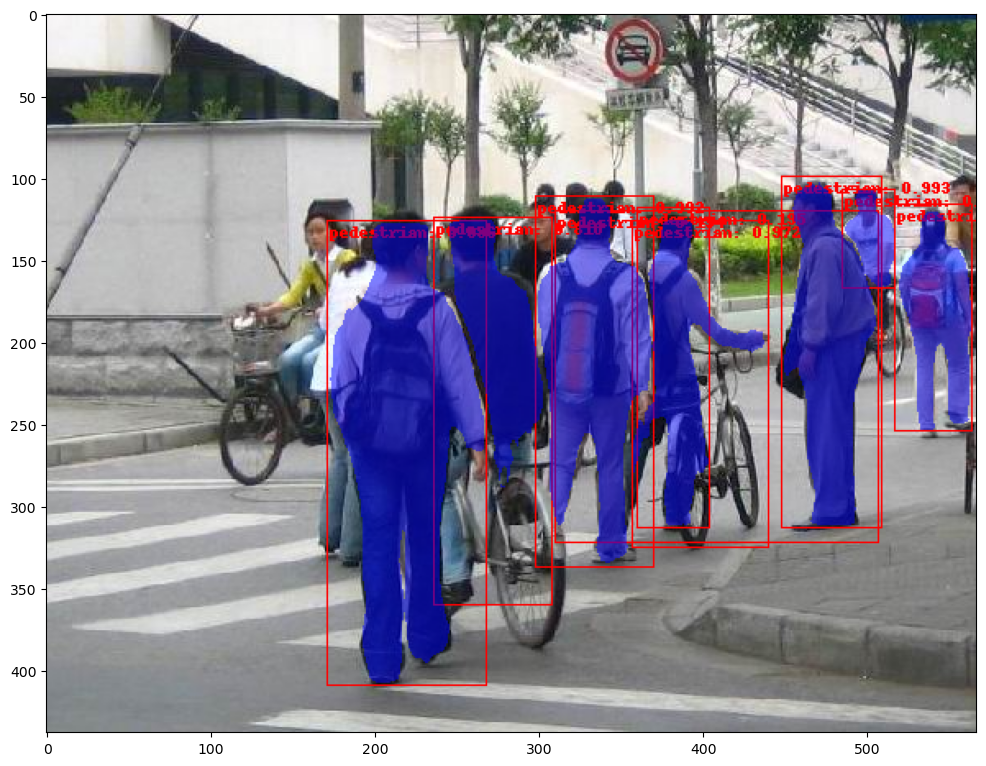

In [33]:
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0));

The results look good!

**Note added**    
- Really? The eyeball test is our benchmark?
- As before, no discussion of what we just did, what formate the prediction takes, how it differs from training, how to narrow down based on confidence. I can figure this out, but egads this really doesn't have much by way of explanation.

## Wrapping up 
In this tutorial, you have learned how to create your own training pipeline for object detection models on a custom dataset. For that, you wrote a torch.utils.data.Dataset class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU training, check references/detection/train.py, which is present in the torchvision repository:

https://github.com/pytorch/vision/blob/main/references/detection/train.py